In [4]:
import pandas as pd
import numpy as np
#import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
#import seaborn as sns
#import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import time 
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 

%matplotlib inline

#from gensim.models import Word2Vec
#import gensim.downloader as api

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [5]:
## Downcasting for memory reduction helper function

def downcast(df):
    dtypes = df.dtypes
    cols = dtypes.index.tolist()
    types = dtypes.values.tolist()
    
    for col, typ in zip(cols, types):
        
        if 'int' in str(typ):
            if df[col].min() > np.iinfo(np.int8).min and \
                df[col].max() < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif df[col].min() > np.iinfo(np.int16).min and \
                df[col].max() < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
                
            elif df[col].min() > np.iinfo(np.int32).min and \
                df[col].max() < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
                
            else:
                df[col] = df[col].astype(np.int64)
                
        elif 'float' in str(typ):
            if df[col].min() > np.finfo(np.float16).min and \
                df[col].max() < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
                
            elif df[col].min() > np.finfo(np.float32).min and \
                df[col].max() < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
                
            else:
                df[col] = df[col].astype(np.float64)
                
        elif typ == np.object:
            if col == 'date':
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
                
            else:
                df[col] = df[col].astype('category')
    
    return df

In [6]:
def import_files():
    print('Reading files...')
    
    
    calendar = pd.read_csv('calendar.csv')
    calendar = downcast(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('sell_prices.csv.zip')
    sell_prices = downcast(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    sales = pd.read_csv('sales_train_validation.csv.zip')
    sales = downcast(sales)
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    
    submission = pd.read_csv('sample_submission.csv.zip')
    
    gc.collect()
    
    return calendar, sell_prices, sales, submission


calendar,sell_prices, sales, submission = import_files()


Reading files...
Calendar has 1969 rows and 14 columns
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [7]:
## Serializing (with pickle)
with open('/home/jupyter-kamakshi_prasad/calendar.pkl', 'wb') as f:
    pickle.dump(calendar, f)

with open('/home/jupyter-kamakshi_prasad/sell_prices.pkl', 'wb') as f:
    pickle.dump(sell_prices, f)
    
with open('/home/jupyter-kamakshi_prasad/sales.pkl', 'wb') as f:
    pickle.dump(sales, f)

In [9]:
def add_dateparts(calendar, datecolname):
    calendar["Date"] = pd.to_datetime(calendar[datecolname], format = ("%Y-%m-%d"))
    calendar["Year"] = calendar["Date"].dt.year
    calendar["Quarter"] = calendar["Date"].dt.quarter
    calendar["Month"] = calendar["Date"].dt.month
    calendar["Week"] = calendar["Date"].dt.week
    calendar["Day"] = calendar["Date"].dt.day
    calendar["DOW"] = calendar["Date"].dt.dayofweek
    calendar = downcast(calendar)
    return calendar

In [10]:
add_dateparts(calendar,"date")

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,Date,Year,Quarter,Month,Week,Day,DOW
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,2011-01-29,2011,1,1,4,29,5
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,2011-01-30,2011,1,1,4,30,6
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,2011-01-31,2011,1,1,5,31,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,2011-02-01,2011,1,2,5,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,2011-02-02,2011,1,2,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,2016-06-15,2016,2,6,24,15,2
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,2016-06-16,2016,2,6,24,16,3
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,2016-06-17,2016,2,6,24,17,4
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,2016-06-18,2016,2,6,24,18,5


In [11]:
print(calendar.head())
print(sales.head())
print(sell_prices.head())

        date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0 2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1 2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2 2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3 2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4 2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  \
0          NaN          NaN          NaN        0        0        0   
1          NaN          NaN          NaN        0        0        0   
2          NaN          NaN          NaN        0        0        0   
3          NaN          NaN          NaN        1        1        0   
4          NaN          NaN          NaN        1        0        1   

        Date  Year  Quarter  Month  Week  Day  DOW  
0 2011-01-29  2011        1      1     4   29    5  
1 2011-01-30  2011    

In [12]:
#Create date index
date_index = calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S').date() for date in dates]

In [13]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales['item_store_id'] = sales.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)
DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,...,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,...,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,...,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,...,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


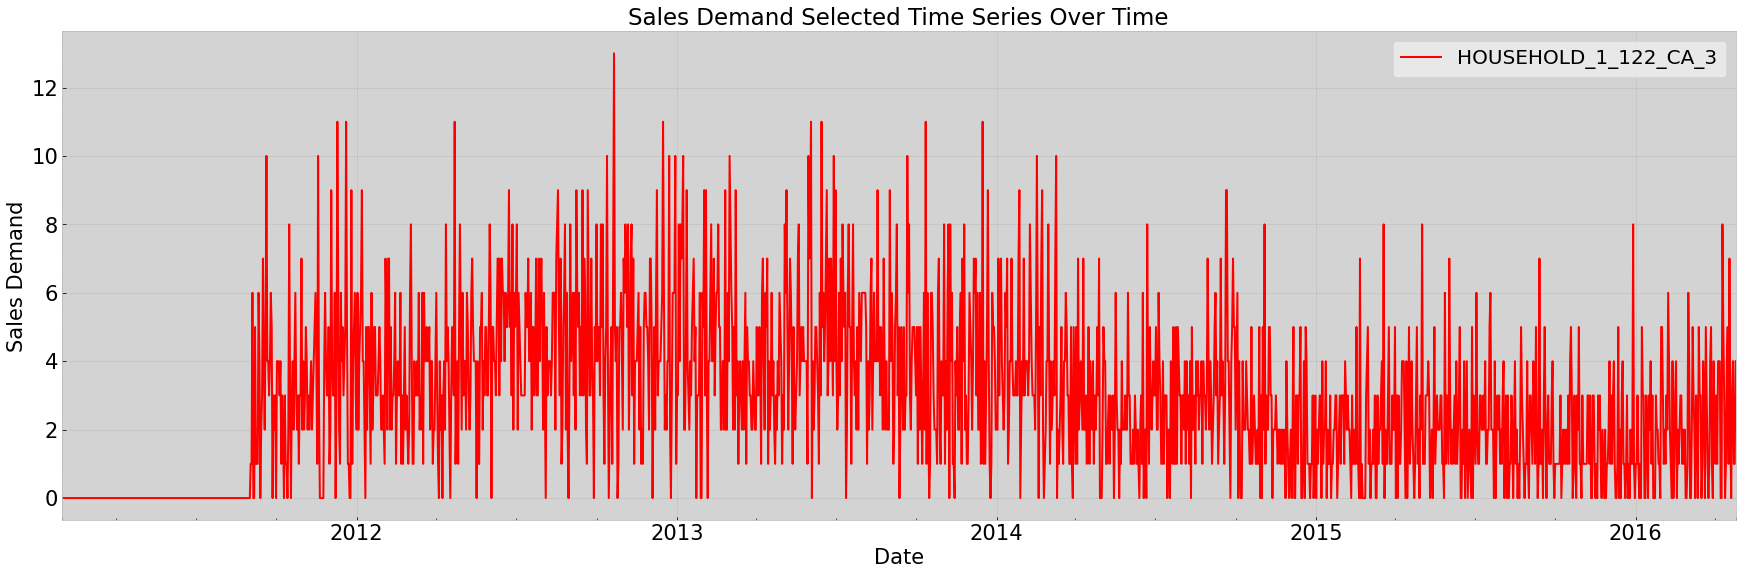

In [15]:
#Select arbitrary index and plot the time series
index = 6780
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 9),color='red')
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [16]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

In [17]:
# Normalize data
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [18]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
[[-0.53846154]
 [-0.38461538]
 [-0.84615385]
 [-0.84615385]
 [-0.38461538]]


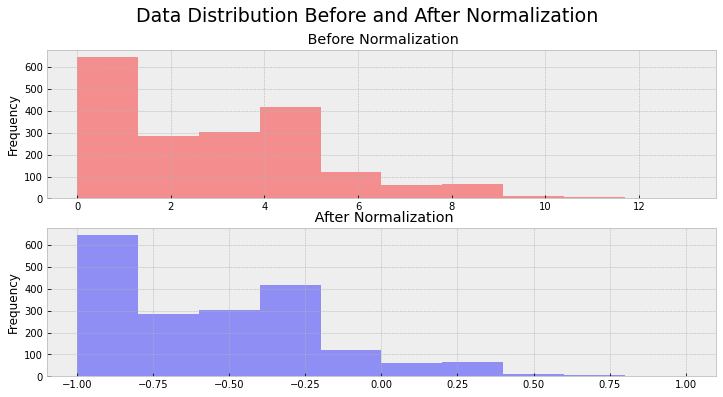

In [19]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Normalization',color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Normalization'\
                                         ,color = 'blue')

In [20]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [21]:
#train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
seq_length = 28
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


In [22]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [23]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1262, 28, 1])
train label shape is: torch.Size([1262, 1])
test shape is: torch.Size([622, 28, 1])
test label shape is: torch.Size([622, 1])


In [24]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [25]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [26]:
#####  Parameters  ######################
num_epochs = 150
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1
#device = 'cuda:0'
device = 'cpu'

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 0.38181 valid loss:  0.40847 
Epoch: 50, loss: 0.16673 valid loss:  0.10819 
Epoch: 100, loss: 0.15987 valid loss:  0.10522 


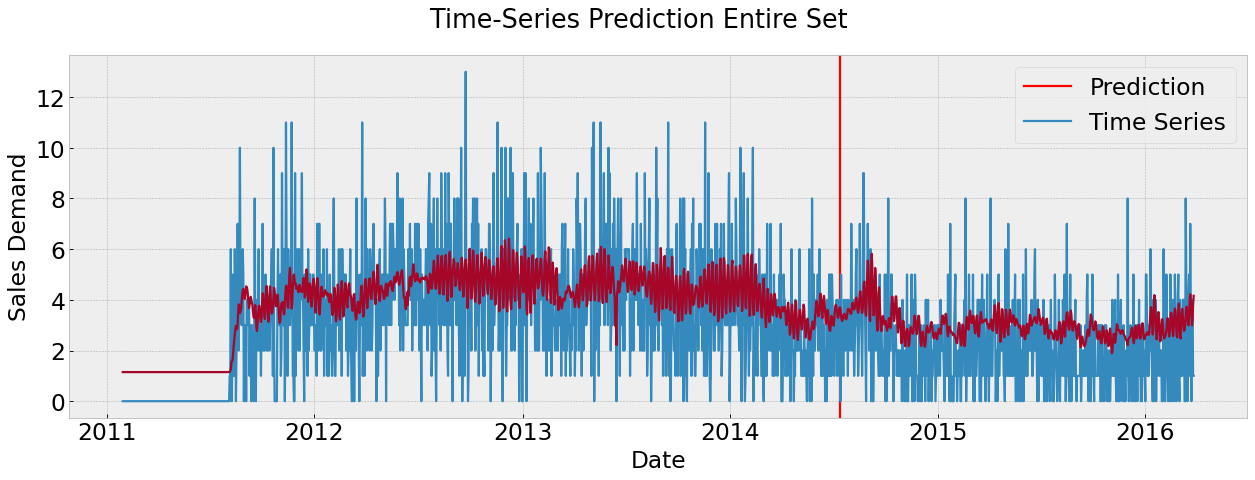

In [38]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

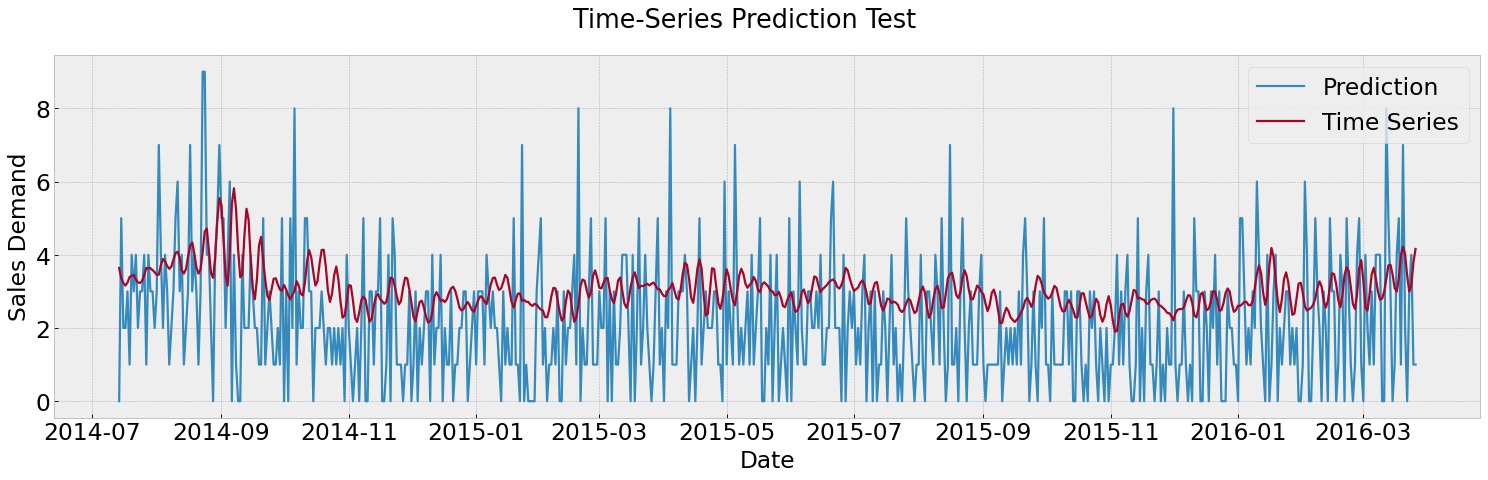

In [39]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

In [40]:
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

1.9173236

In [1]:
df = pd.melt(
    sales,
    id_vars=[
        'id',
        'item_id',
        'dept_id',
        'cat_id',
        'store_id',
        'state_id'
    ],
    var_name='d',
    value_name='sold')

df.head()

NameError: name 'pd' is not defined